In [ ]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**Introduction to the tf.data.Dataset class.**

In [ ]:
# using from_tensors, returns a single tensor.
dataset = tf.data.Dataset.from_tensors([8, 3, 0, 8, 2, 1])
dataset

<TensorDataset shapes: (6,), types: tf.int32>

In [ ]:
#To display a tensor, use tensor.numpy() function, to view the complete dataset
for elem in dataset:
  print(elem.numpy())

[8 3 0 8 2 1]


In [ ]:
#Creating a dataset from data in memory - tf.data.datset.from_tensor_slices()
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [ ]:
#Consuming data using for loop.
for elem in dataset:
  print(elem.numpy())

8
3
0
8
2
1


In [ ]:
#Consuming data using python iterator.
it = iter(dataset)

for x in it:
  print(x.numpy())

8
3
0
8
2
1


In [ ]:
# Dataset elements can be consumed using the reduce transformation. This can be used if implementing custom losses.
print(dataset.reduce(0, lambda state, value: state + value).numpy()) #initial_state, callable

22


In [ ]:
dataset1 = tf.data.Dataset.from_tensors(tf.random.uniform([4, 10]))

dataset1.element_spec #element spec can be used to check the propeties of an individual element in the dataset.

TensorSpec(shape=(4, 10), dtype=tf.float32, name=None)

In [ ]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [ ]:
#can also pass a tuple.
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4, 100], maxval=100, dtype=tf.int32), tf.random.uniform([4])
    ))

dataset2.element_spec

(TensorSpec(shape=(100,), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [ ]:
#We can create a nested structure by applying tranformations on tf.Datasets

dataset3  = tf.data.Dataset.zip((dataset1, dataset2))
dataset3

<ZipDataset shapes: ((10,), ((100,), ())), types: (tf.float32, (tf.int32, tf.float32))>

**Loading Input Data**

In [ ]:
# Using numpy arrays
 

#first load thew data from .npz file

#DATA_URL for the mnist dataset, can also be a path in the local file system.
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz' 

path = tf.keras.utils.get_file('mnist.npz', DATA_URL) #Since we are using a data url, this will return the path to the file.
#if file is in the local file system, simply use np.load(path)
with np.load(path) as data:
  train_examples = data['x_train'] #Array of train examples
  train_labels = data['y_train'] #corresponding array of labels, one - hot vectors
  test_examples = data['x_test']
  test_labels = data['y_test']

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_examples.shape, train_labels.shape #Batch first

((60000, 28, 28), (60000,))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels)) #(example, taget) tuple
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

In [ ]:
# Using python generator, can be useful for image data, since the ImageDataGenerator api in keras provides a efficient and simple way for processing images.

#ImageDataGenerator - Generate batches of tensor image data with real-time data augmentation.

flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True) #Downloads the data and returns the absolute path to the file.


228818944/228813984 [==============================] - 1s 0us/step


In [ ]:
flowers

'/root/.keras/datasets/flower_photos'

In [ ]:
#now create the ImageDataGenerator, it is used for real time data augmentation.
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20) #returns an image generator

img_gen

In [ ]:
#ImageGenerator.flow() - takes data and label arrays
#ImageGenerator.flow_from_directory - Takes the path to a directory & generates batches of augmented data.

images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [ ]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


In [ ]:
print(labels[0]) #one - hot

[0. 0. 0. 1. 0.]


In [ ]:
print(images[0][0]) #normalized

In [ ]:
ds = tf.data.Dataset.from_generator(
    img_gen.flow_from_directory, args=[flowers], 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,256,256,3], [32,5])
) #create the dataset
ds

<FlatMapDataset shapes: ((32, 256, 256, 3), (32, 5)), types: (tf.float32, tf.float32)>

In [ ]:
# Using CSV data

titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")


32768/30874 [===============================] - 0s 0us/step


In [ ]:
df = pd.read_csv(titanic_file, index_col=None)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived") #can also use tf.data.Dataset.from_tensor_slices(dict(df)) if data fits in memory

In [ ]:
for feature_batch, label_batch in titanic_batches.take(1): #The first column is the label
  print("'survived': {}".format(label_batch))
  print("features:")
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [1 1 0 1]
features:
  'sex'               : [b'male' b'female' b'male' b'male']
  'age'               : [28. 53. 46. 36.]
  'n_siblings_spouses': [0 2 1 0]
  'parch'             : [0 0 0 0]
  'fare'              : [ 7.2292 51.4792 61.175  26.3875]
  'class'             : [b'Third' b'First' b'First' b'First']
  'deck'              : [b'unknown' b'C' b'E' b'E']
  'embark_town'       : [b'Cherbourg' b'Southampton' b'Southampton' b'Southampton']
  'alone'             : [b'y' b'n' b'n' b'y']


**Batching Dataset Elements**

In [ ]:
# In batching, we stack n consecutive elements as a single element, to use tf.dataset.batch, all elements should be tensors and have exact same shape.
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

In [ ]:
for batch in batched_dataset.take(4): # print first four batches.
  #batch will be a tuple.
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


In [ ]:
for batch in dataset.batch(7): #when batch_size is not  a multiple of the total no of elements.
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3, 4, 5, 6]), array([ 0, -1, -2, -3, -4, -5, -6])]
[array([ 7,  8,  9, 10, 11, 12, 13]), array([ -7,  -8,  -9, -10, -11, -12, -13])]
[array([14, 15, 16, 17, 18, 19, 20]), array([-14, -15, -16, -17, -18, -19, -20])]
[array([21, 22, 23, 24, 25, 26, 27]), array([-21, -22, -23, -24, -25, -26, -27])]
[array([28, 29, 30, 31, 32, 33, 34]), array([-28, -29, -30, -31, -32, -33, -34])]
[array([35, 36, 37, 38, 39, 40, 41]), array([-35, -36, -37, -38, -39, -40, -41])]
[array([42, 43, 44, 45, 46, 47, 48]), array([-42, -43, -44, -45, -46, -47, -48])]
[array([49, 50, 51, 52, 53, 54, 55]), array([-49, -50, -51, -52, -53, -54, -55])]
[array([56, 57, 58, 59, 60, 61, 62]), array([-56, -57, -58, -59, -60, -61, -62])]
[array([63, 64, 65, 66, 67, 68, 69]), array([-63, -64, -65, -66, -67, -68, -69])]
[array([70, 71, 72, 73, 74, 75, 76]), array([-70, -71, -72, -73, -74, -75, -76])]
[array([77, 78, 79, 80, 81, 82, 83]), array([-77, -78, -79, -80, -81, -82, -83])]
[array([84, 85, 86, 87, 88, 89

In [ ]:
for batch in dataset.batch(7, drop_remainder=True):
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3, 4, 5, 6]), array([ 0, -1, -2, -3, -4, -5, -6])]
[array([ 7,  8,  9, 10, 11, 12, 13]), array([ -7,  -8,  -9, -10, -11, -12, -13])]
[array([14, 15, 16, 17, 18, 19, 20]), array([-14, -15, -16, -17, -18, -19, -20])]
[array([21, 22, 23, 24, 25, 26, 27]), array([-21, -22, -23, -24, -25, -26, -27])]
[array([28, 29, 30, 31, 32, 33, 34]), array([-28, -29, -30, -31, -32, -33, -34])]
[array([35, 36, 37, 38, 39, 40, 41]), array([-35, -36, -37, -38, -39, -40, -41])]
[array([42, 43, 44, 45, 46, 47, 48]), array([-42, -43, -44, -45, -46, -47, -48])]
[array([49, 50, 51, 52, 53, 54, 55]), array([-49, -50, -51, -52, -53, -54, -55])]
[array([56, 57, 58, 59, 60, 61, 62]), array([-56, -57, -58, -59, -60, -61, -62])]
[array([63, 64, 65, 66, 67, 68, 69]), array([-63, -64, -65, -66, -67, -68, -69])]
[array([70, 71, 72, 73, 74, 75, 76]), array([-70, -71, -72, -73, -74, -75, -76])]
[array([77, 78, 79, 80, 81, 82, 83]), array([-77, -78, -79, -80, -81, -82, -83])]
[array([84, 85, 86, 87, 88, 89

**Preprocessing Data**

In [ ]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

In [ ]:
flowers_root

PosixPath('/root/.keras/datasets/flower_photos')

In [ ]:
#The root directory contains a directory for each class:

for item in flowers_root.glob("*"):
  print(item.name)

roses
dandelion
tulips
LICENSE.txt
sunflowers
daisy


In [ ]:
#The files in each class directory are examples:

list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

for f in list_ds.take(5):
  print(f.numpy())

In [ ]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep) # Seperates the name and label
  label = parts[-2]

  image = tf.io.read_file(filename) 
  image = tf.image.decode_jpeg(image) #Decode a JPEG-encoded image to a uint8 tensor.
  image = tf.image.convert_image_dtype(image, tf.float32) # Good practice to enforce the dataset.
  image = tf.image.resize(image, [128, 128])
  return image, label

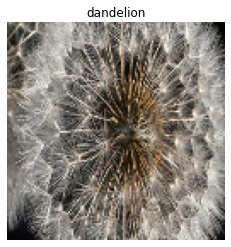

In [ ]:
#testing the above function
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

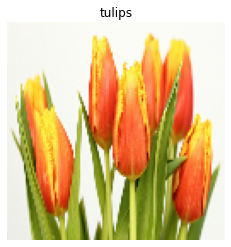

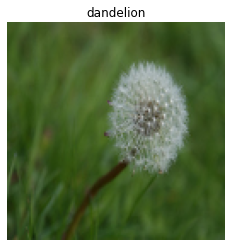

In [ ]:
images_ds = list_ds.map(parse_image) # map over the entire dataset.

for image, label in images_ds.take(2):
  show(image, label)

**A simple end to end example**<br/>
This example shows how the tensorflow datasets are used with keras.

In [ ]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0 # normalize images
labels = labels.astype(np.int32) 

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
images.shape, labels.shape

((60000, 28, 28), (60000,))

In [ ]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

#Keras has sequential, functional api for building models. This is an example of  a simple perceptron model.
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
fmnist_train_ds

<BatchDataset shapes: ((None, 28, 28), (None,)), types: (tf.float64, tf.int32)>

In [ ]:
model.fit(fmnist_train_ds, epochs=2) #pass a dataset with train_image, train_label

Epoch 1/2

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1875/1875 [==============================] - 2s 1ms/step - loss: 0.5971 - accuracy: 0.7999
Epoch 2/2
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4620 - accuracy: 0.8411


In [ ]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

1875/1875 [==============================] - 2s 948us/step - loss: 0.4441 - accuracy: 0.8467
Loss : 0.44413745403289795
Accuracy : 0.8467333316802979
